In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Kedro to Hamilton plugin [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/kedro/kedro-plugin/kedro_to_hamilton.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/kedro/kedro-plugin/kedro_to_hamilton.ipynb)


The plugin allows you to convert a Kedro `Pipeline` object in to a valid Hamilton `Driver`. This allows you to execute your Kedro pipeline on Hamilton and track execution using the [Hamilton UI](https://hamilton.dagworks.io/en/latest/concepts/ui/), which provides rich observability and introspection features.


## Content
1. From Kedro `Pipeline` to Hamilton `Driver`
2. Executing the `Driver`
3. Reusing your Kedro `DataCatalog`
4. Using Hamilton materialization
5. Connect to the Hamilton UI

## Prerequisite
Install the example Kedro project by executing the next cell

In [ ]:
!pip install ../kedro-code
import warnings
warnings.filterwarnings("ignore")

## 1. From `Pipeline` to `Driver`
We import from the Kedro project `kedro_code` the modules `data_processing` to create a `Pipeline` object. Then, we pass it to the Hamilton plugin using `h_kedro.kedro_pipeline_to_driver()` to create a Hamilton `Driver`. It can be viewed, executed, and supports all `Driver` operations!

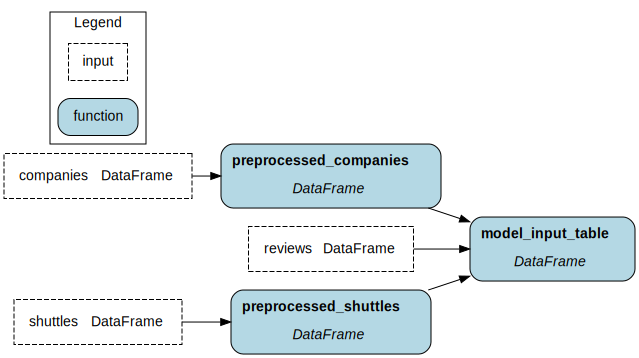

In [2]:
from hamilton.plugins import h_kedro
from kedro_code.pipelines import data_processing

dr = h_kedro.kedro_pipeline_to_driver(data_processing.create_pipeline())
dr

You can also pass multiple Kedro `Pipeline` to compose them together in a single Hamilton `Driver`

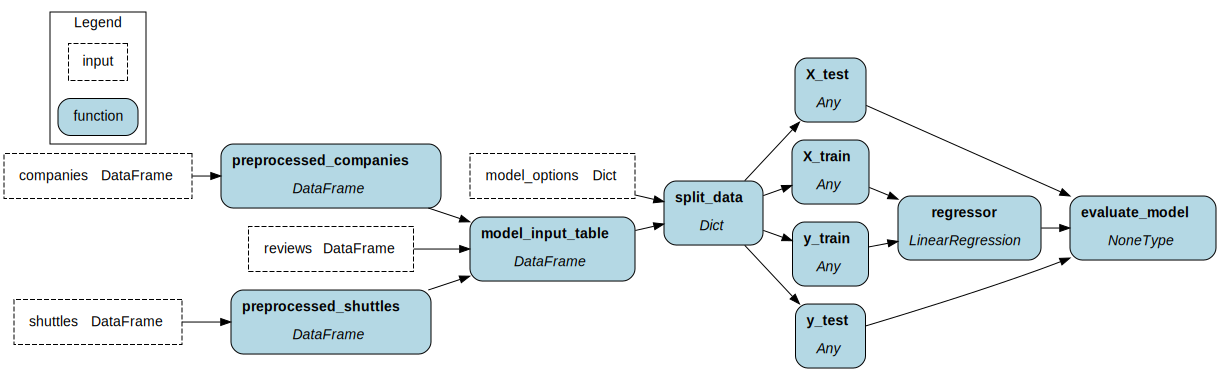

In [3]:
from hamilton.plugins import h_kedro
from kedro_code.pipelines import data_processing, data_science

dr = h_kedro.kedro_pipeline_to_driver(
    data_processing.create_pipeline(),
    data_science.create_pipeline(),
)
dr

## 2. Execute the `Driver`
You can execute `Driver` using the regular Hamilton approach. We load data from files and pass it to `Driver.execute(inputs=...)`

In [4]:
import pandas as pd

# loading stored data
inputs=dict(
    companies=pd.read_csv("../kedro-code/data/01_raw/companies.csv"),
    reviews=pd.read_csv("../kedro-code/data/01_raw/reviews.csv"),
    shuttles=pd.read_excel("../kedro-code/data/01_raw/shuttles.xlsx"),
)
results = dr.execute(["model_input_table"], inputs=inputs)
results["model_input_table"].head()

,shuttle_location,shuttle_type,engine_type,engine_vendor,engines,passenger_capacity,cancellation_policy,crew,d_check_complete,moon_clearance_complete,...,review_scores_crew,review_scores_location,review_scores_price,number_of_reviews,reviews_per_month,id,company_rating,company_location,total_fleet_count,iata_approved
0,Sao Tome and Principe,Type V5,Plasma,ThetaBase Services,2.0,4,moderate,2.0,False,False,...,9.0,9.0,9.0,26,0.77,32413,1.0,Faroe Islands,1.0,False
1,Wallis and Futuna,Type V2,Plasma,ThetaBase Services,3.0,5,moderate,3.0,False,False,...,10.0,10.0,9.0,61,0.62,14122,1.0,Malta,1.0,True
2,Niue,Type F5,Quantum,ThetaBase Services,1.0,2,strict,1.0,True,False,...,10.0,10.0,10.0,467,4.66,47761,1.0,Niue,2.0,False
3,Malta,Type V2,Quantum,ThetaBase Services,1.0,2,moderate,1.0,False,False,...,10.0,9.0,9.0,318,3.22,26648,1.0,Niue,2.0,True
4,Malta,Type V2,Plasma,ThetaBase Services,5.0,10,strict,5.0,False,False,...,10.0,9.0,10.0,22,0.29,26648,1.0,Niue,2.0,True


## 3. Reuse the Kedro `DataCatalog`
If you have an existing Kedro project with a `DataCatalog` (probably in a `.yaml` file), you can directly reuse it. In Hamilton, both datasets and "parameters" can be passed to `Driver.execute(inputs=...)`. 

To do so, you need to load the Kedro project and access the catalog and parameters from the `KedroSession`

In [5]:
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project

project_path = "../kedro-code"
bootstrap_project(project_path)
with KedroSession.create(project_path) as session:
    context = session.load_context()
    catalog = context.catalog
    params = context.params

inputs = dict(
    companies=catalog.load("companies"),
    reviews=catalog.load("reviews"),
    shuttles=catalog.load("shuttles"),
    **params,  # unpack a dictionary
)

results = dr.execute(["model_input_table"], inputs=inputs)
results["model_input_table"].head()

[05/22/24 16:10:54] INFO     Loading data from companies (CSVDataset)...                        ]8;id=554145;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=747028;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Loading data from reviews (CSVDataset)...                          ]8;id=756925;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7965;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Loading data from shuttles (ExcelDataset)...                       ]8;id=791772;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=315027;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

,shuttle_location,shuttle_type,engine_type,engine_vendor,engines,passenger_capacity,cancellation_policy,crew,d_check_complete,moon_clearance_complete,...,review_scores_crew,review_scores_location,review_scores_price,number_of_reviews,reviews_per_month,id,company_rating,company_location,total_fleet_count,iata_approved
0,Sao Tome and Principe,Type V5,Plasma,ThetaBase Services,2.0,4,moderate,2.0,False,False,...,9.0,9.0,9.0,26,0.77,32413,1.0,Faroe Islands,1.0,False
1,Wallis and Futuna,Type V2,Plasma,ThetaBase Services,3.0,5,moderate,3.0,False,False,...,10.0,10.0,9.0,61,0.62,14122,1.0,Malta,1.0,True
2,Niue,Type F5,Quantum,ThetaBase Services,1.0,2,strict,1.0,True,False,...,10.0,10.0,10.0,467,4.66,47761,1.0,Niue,2.0,False
3,Malta,Type V2,Quantum,ThetaBase Services,1.0,2,moderate,1.0,False,False,...,10.0,9.0,9.0,318,3.22,26648,1.0,Niue,2.0,True
4,Malta,Type V2,Plasma,ThetaBase Services,5.0,10,strict,5.0,False,False,...,10.0,9.0,10.0,22,0.29,26648,1.0,Niue,2.0,True


## 4. Use Hamilton materializers

The concept of [materialization](https://hamilton.dagworks.io/en/latest/concepts/materialization/#) in Hamilton closely ressembles `Dataset` objects in Kedro. The `from_` object defines loaders and `to` defines savers, and they're collectively called "materializers".

If you're using Hamilton, you'll find plenty of savers & loaders for common formats and libraries (`parquet`, `csv`, `json`, `xgboost`, `dlt`, etc.). We suggest using them directly if you're wanting to move away from the data catalog and YAML.

In [6]:
from hamilton.io.materialization import from_, to

# contains both Savers and Loaders
materializers = [
    # `target` is the name of the Hamilton node receiving data
    from_.csv(
        target="companies",
        path="../kedro-code/data/01_raw/companies.csv",
    ), 
    from_.csv(
        target="reviews",
        path="../kedro-code/data/01_raw/reviews.csv",
    ), 
    from_.excel(
        target="shuttles",
        path="../kedro-code/data/01_raw/shuttles.xlsx",
    ),
    # `id` is the name of the generated "saver" node
    to.parquet(
        id="model_input_table__parquet",
        dependencies=["model_input_table"],
        path="../kedro-code/data/03_primary/model_input_table.pq",
    )
]

# `.materialize()` will load data using `from_` objects and store results of `to` objects
# it returns execution metadata about stored results.
metadata, _ = dr.materialize(*materializers)
metadata


{
    'model_input_table__parquet': {
        'file_metadata': {
            'size': 215150,
            'path': '../kedro-code/data/03_primary/model_input_table.pq',
            'last_modified': 1716408659.312288,
            'timestamp': 1716423059.328785,
            'scheme': '',
            'notes': ''
        },
        'dataframe_metadata': {
            'rows': 6027,
            'columns': 27,
            'column_names': [
                'shuttle_location',
                'shuttle_type',
                'engine_type',
                'engine_vendor',
                'engines',
                'passenger_capacity',
                'cancellation_policy',
                'crew',
                'd_check_complete',
                'moon_clearance_complete',
                'price',
                'company_id',
                'shuttle_id',
                'review_scores_rating',
                'review_scores_comfort',
                'review_scores_amenities',
                

If Hamilton doesn't support a specific format, you can use Kedro datasets using the `from_.kedro()` and `to.kedro()` materializers!

This first snippet shows how to read from the `DataCatalog` defined in YAML format within the Kedro project.

In [7]:
project_path = "../kedro-code"
bootstrap_project(project_path)
with KedroSession.create(project_path) as session:
    context = session.load_context()
    catalog = context.catalog
    params = context.params

# pass the `DataCatalog` to the `catalog` parameter
materializers = [
    from_.kedro(
        target="companies",
        dataset_name="companies",
        catalog=catalog,
    ),
    from_.kedro(
        target="shuttles",
        dataset_name="shuttles",
        catalog=catalog,
    ),
    from_.kedro(
        target="reviews",
        dataset_name="reviews",
        catalog=catalog,
    ),
    to.kedro(
        id="model_input_table__parquet",
        dependencies=["model_input_table"],
        dataset_name="model_input_table",
        catalog=catalog,
    ),
]
metadata, _ = dr.materialize(*materializers)
metadata

[05/22/24 16:10:59] INFO     Loading data from shuttles (ExcelDataset)...                       ]8;id=251889;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=569579;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

[05/22/24 16:11:01] INFO     Loading data from companies (CSVDataset)...                        ]8;id=698982;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=247154;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Loading data from reviews (CSVDataset)...                          ]8;id=651853;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=754005;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

[05/22/24 16:11:02] INFO     Saving data to model_input_table (ParquetDataset)...               ]8;id=845498;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=59594;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#525\525]8;;\

{'model_input_table__parquet': {'success': True}}

This second snippet shows how to define a `DataCatalog` directly in Python ([documentation](https://docs.kedro.org/en/stable/data/advanced_data_catalog_usage.html)). Note that in this case, all formats are already supported in Hamilton and it makes code a bit redundant.

In [8]:
from kedro.io import DataCatalog
from kedro_datasets.pandas import (
    CSVDataset,
    ExcelDataset,
    ParquetDataset,
)

catalog = DataCatalog(dict(
    companies=CSVDataset(filepath="../kedro-code/data/01_raw/companies.csv"),
    reviews=CSVDataset(filepath="../kedro-code/data/01_raw/reviews.csv"),
    shuttles=ExcelDataset(filepath="../kedro-code/data/01_raw/shuttles.xlsx"),
    model_input_table=ParquetDataset(filepath="../kedro-code/data/03_primary/model_input_table.pq")
))

materializers = [
    from_.kedro(
        target="companies",
        dataset_name="companies",
        catalog=catalog,
    ),
    from_.kedro(
        target="shuttles",
        dataset_name="shuttles",
        catalog=catalog,
    ),
    from_.kedro(
        target="reviews",
        dataset_name="reviews",
        catalog=catalog,
    ),
    to.kedro(
        id="model_input_table__parquet",
        dependencies=["model_input_table"],
        dataset_name="model_input_table",
        catalog=catalog,
    ),
]
metadata, _ = dr.materialize(*materializers)
metadata

                    INFO     Loading data from shuttles (ExcelDataset)...                       ]8;id=765638;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=540969;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

[05/22/24 16:11:04] INFO     Loading data from companies (CSVDataset)...                        ]8;id=845539;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=373818;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Loading data from reviews (CSVDataset)...                          ]8;id=673966;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=380648;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Saving data to model_input_table (ParquetDataset)...               ]8;id=611834;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=912002;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#525\525]8;;\

{'model_input_table__parquet': {'success': True}}

## 5. Connect to the Hamilton UI

To connect Hamilton to the Hamilton UI, we need to add the `HamiltonTracker` adapter. To connect your Kedro `Pipeline`, you need to pass a `Builder` containing the tracker when converting it to a Hamilton `Driver`. 

The next cell will install the dependencies for the UI. You also need the Hamilton UI container running for the next cells to successfully execute and send metadata. See [installation instructions](https://hamilton.dagworks.io/en/latest/concepts/ui/).

In [ ]:
!pip install hamilton_sdk

Running the next cell and creating the `Driver` should populate the Hamilton UI with the dataflow definition.

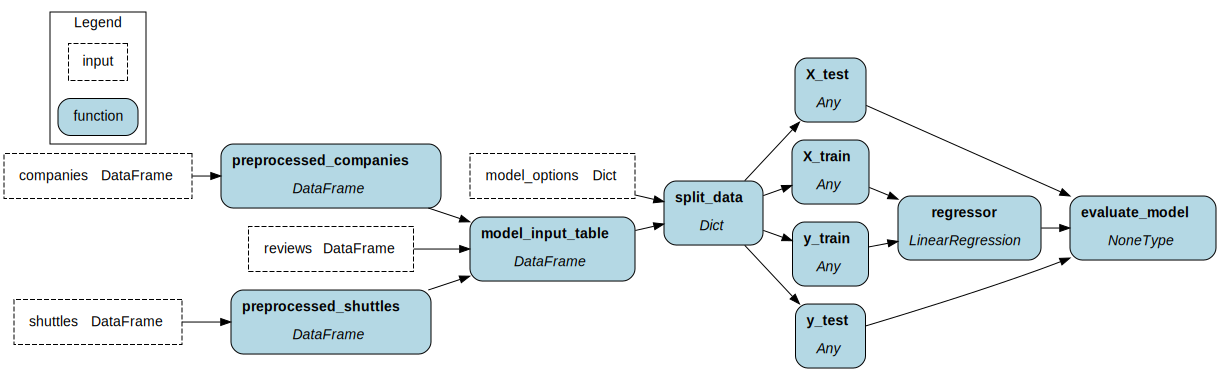

In [10]:
from hamilton_sdk.adapters import HamiltonTracker
from hamilton import driver
from hamilton.plugins import h_kedro
from kedro_code.pipelines import data_processing, data_science

# modify this as needed
tracker = HamiltonTracker(
    project_id=3,
    username="abc@my_domain.com",
    dag_name="spaceflight",
)
builder = driver.Builder().with_adapters(tracker)

dr = h_kedro.kedro_pipeline_to_driver(
    data_processing.create_pipeline(),
    data_science.create_pipeline(),
    builder=builder
)
dr

Calling `.materialize()` in the next cell (or using `.execute()`) will populate the Hamilton UI with execution metadata and artifact introspection

In [11]:
# reuse the previously defined materializers
_, _ = dr.materialize(*materializers)

[05/22/24 16:11:10] WARNING                                                                         ]8;id=299905;file:///home/tjean/projects/dagworks/hamilton/ui/sdk/src/hamilton_sdk/adapters.py\adapters.py]8;;\:]8;id=155714;file:///home/tjean/projects/dagworks/hamilton/ui/sdk/src/hamilton_sdk/adapters.py#163\163]8;;\
                             Capturing execution run. Results can be found at                                      
                             http://localhost:8242/dashboard/project/3/runs/32                                     
                                                                                                                   

                    INFO     Loading data from shuttles (ExcelDataset)...                       ]8;id=976064;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997503;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

[05/22/24 16:11:13] INFO     Loading data from companies (CSVDataset)...                        ]8;id=134319;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=446665;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Loading data from reviews (CSVDataset)...                          ]8;id=620527;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=424729;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#483\483]8;;\

                    INFO     Saving data to model_input_table (ParquetDataset)...               ]8;id=102118;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=182015;file:///home/tjean/projects/dagworks/hamilton/examples/kedro/venv/lib/python3.11/site-packages/kedro/io/data_catalog.py#525\525]8;;\

                    WARNING                                                                         ]8;id=48567;file:///home/tjean/projects/dagworks/hamilton/ui/sdk/src/hamilton_sdk/adapters.py\adapters.py]8;;\:]8;id=639017;file:///home/tjean/projects/dagworks/hamilton/ui/sdk/src/hamilton_sdk/adapters.py#352\352]8;;\
                             Captured execution run. Results can be found at                                       
                             http://localhost:8242/dashboard/project/3/runs/32                                     
                                                                                                                   